### Canny Edge Detection
https://learnopencv.com/edge-detection-using-opencv/

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows
from skimage import io, color

#### Implementing Canny Edge Detection

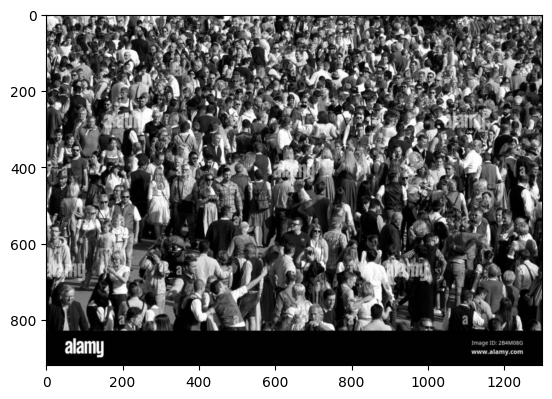

In [42]:
# Read the original image
img = cv2.imread(r"C:\Users\jiayi\OneDrive\Documents\Meta\carpetDetection\photos\crowded.jpg",flags=0)
# img = cv2.imread('../photos/standup_carpet2.png',flags=0)
# img = cv2.imread('../photos/plain.jpg',flags=0)

if img is None:
    print("Error: Unable to load image")

# Blur the image for better edge detection

img_blur = cv2.GaussianBlur(img,(3,3), sigmaX=0, sigmaY=0) 

# show original image using plt
plt.imshow(img_blur, cmap='gray')


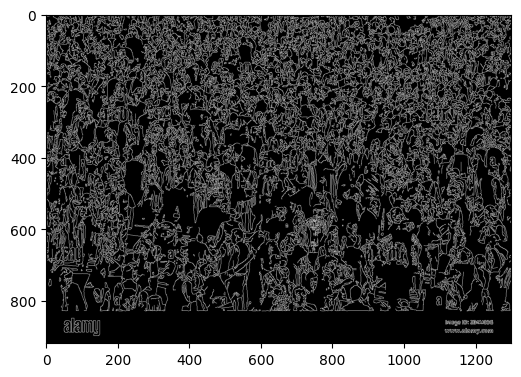

In [43]:
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) 

# show edged image using plt
plt.figure(figsize=(6,6))
plt.imshow(edges, cmap='gray')

### Measuring the amount of edges above threshold
In the context of edge detection, the threshold refers to a value that is used to distinguish between strong and weak edges in the edge-detected image.
A higher threshold will result in fewer strong edges being detected.

Edge count is divided by total pixel count to get edge ratio. Higher ratio means more edge count, and more densed

In [44]:
# Get the dimensions of the image
height, width = edges.shape
print("Dimension:", height,width)

# Set a threshold for edge intensity
# You can adjust this threshold value

# Count the number of edge pixels above the threshold
edge_count = len(edges[edges > 0])
        
print("Edge count:", edge_count)

# Get the total number of pixels in the image
total_pixels = edges.size
print("Total pixels:", total_pixels)

# Calculate the ratio of above_threshold_count to total_pixels
edge_density = edge_count / total_pixels

# Normalise the edge ratio by multiplying 10 so that it's between 0 to 10
normalized_edge_ratio = edge_density

print("Edge density:", normalized_edge_ratio)

Dimension: 919 1300
Edge count: 187336
Total pixels: 1194700
Edge density: 0.1568058926927262


### If edge density is higher than 0.1, perform Local Binary Pattern (LBP)

LBP can be used to check if the pattern is repetitive, patch size is important and cannot be too small

- https://cvexplained.wordpress.com/2020/07/22/10-7-local-binary-patterns/
- https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b
- https://towardsdatascience.com/the-power-of-local-binary-patterns-3134178af1c7


In [45]:
# Parameters
height_patch = height * 0.3
width_patch = width * 0.3
step_size = math.floor(min(height, width) * 0.2)
radius = 1
n_points = 8
patch_size = (height_patch, width_patch)  # Size of patches
step = step_size  # Patch step

print("Patch size:", patch_size)
print("Patch step:", step)

Patch size: (275.7, 390.0)
Patch step: 183


(4, 5, 275, 390)


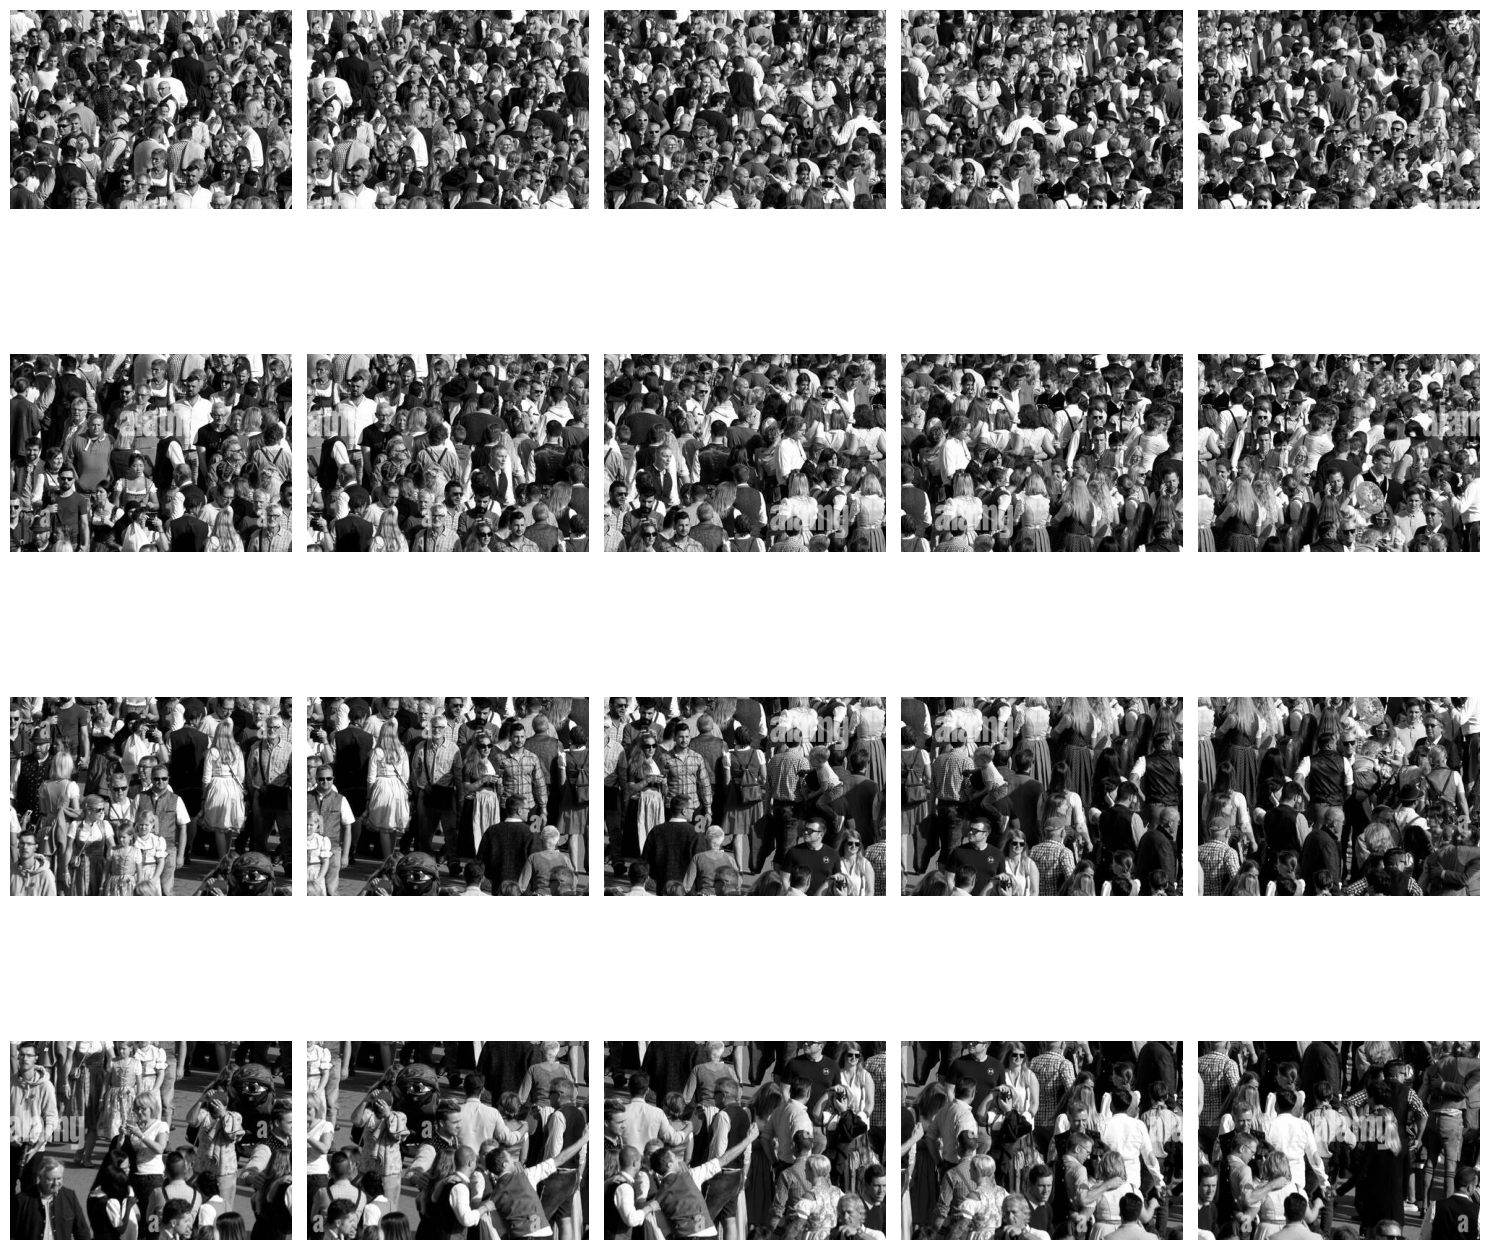

In [46]:
# Calculate LBP histograms for patches
lbp_histograms = []

# Create overlapping patches using view_as_windows
patches = view_as_windows(img, patch_size, step_size)
print(patches.shape)

# Define the number of rows and columns for subplots
num_rows = patches.shape[0]
num_cols = patches.shape[1]

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j]
        
        # Display the patch as an image
        axes[i, j].imshow(patch, cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
        
plt.tight_layout()
plt.show()

In [47]:
def hist(axis, lbp):
    '''
    Create a histogram
    :param axis: matplotlib axes
    :param lbp: ndarray local binary pattern representation of an image
    :return: matplotliob histogram
    '''
    n_bins = int(lbp.max() + 1) # number of bins based on number of different values in lbp
    return axis.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5') 
    # np.ravel() returns a flattened 1D array
    # density=True normalizes the histogram, so that the sum of all bins adds up to 1

#### Generate histogram for each patch

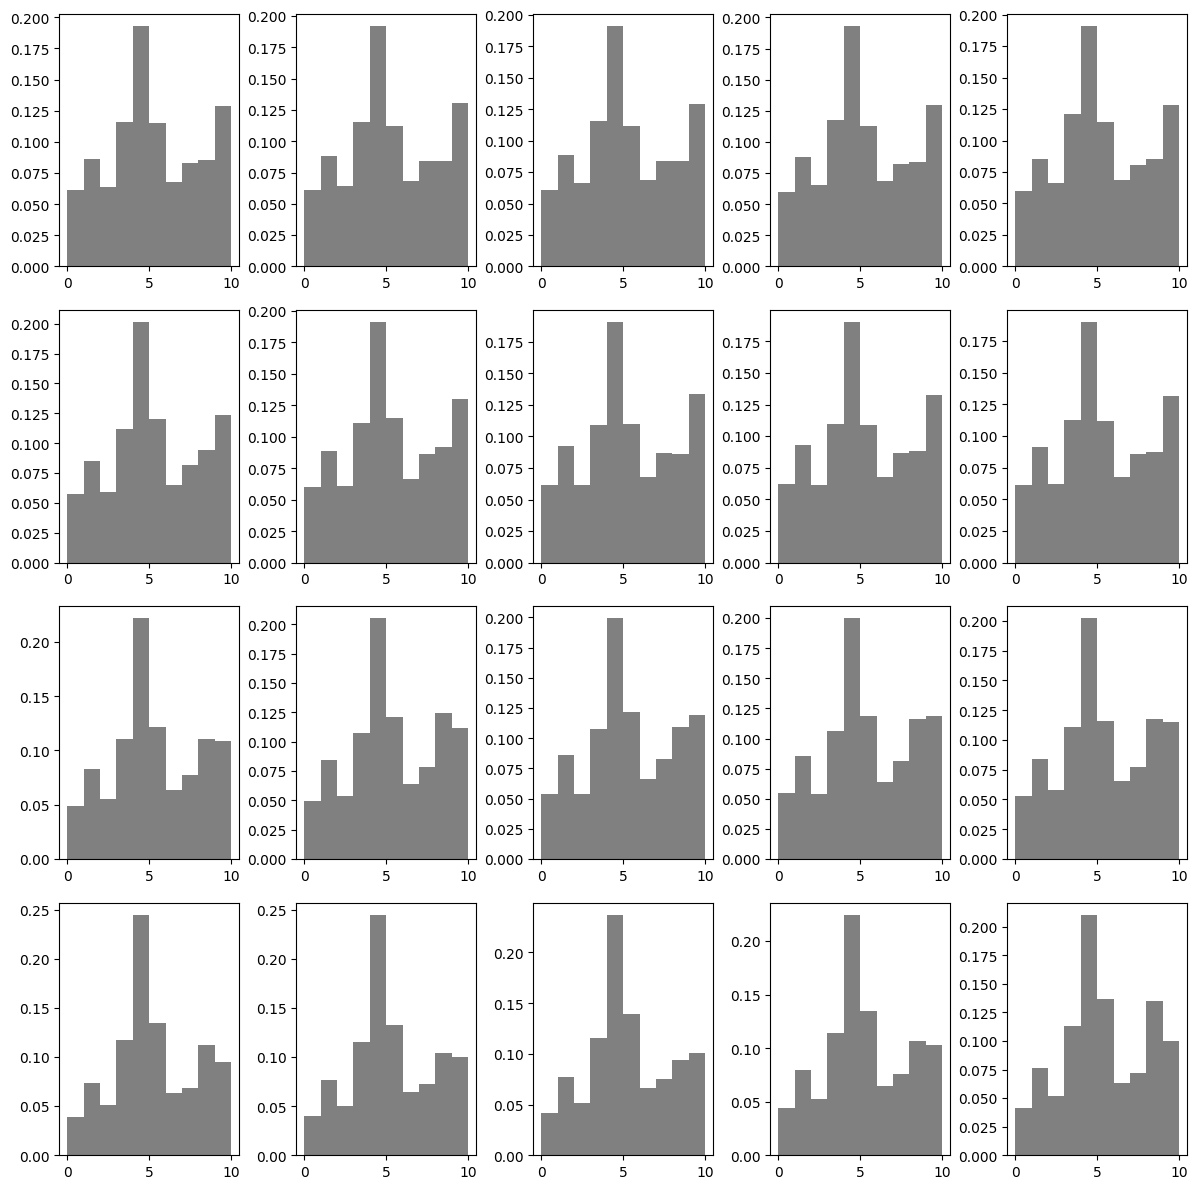

In [48]:
histograms = []
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j]

        # Calculate LBP pattern for the patch
        lbp_img = local_binary_pattern(patch, n_points, radius, method='uniform')
        
        # Plot histogram of LBP of textures
        ax = axes[i, j]
        hist_values = hist(ax, lbp_img)
        
        histograms.append(hist_values)
        # ax.set_xlabel('Uniform LBP values')
        # ax.set_ylabel('Percentage')
        # ax.set_title(f'Patch ({i+1}, {j+1})') 

plt.tight_layout()


### Perform Kullback-Leibler divergence
If the return value is close to zero, it means that the divergence between the two distributions is minimal, and they are very similar.

The bigger the result, the more dissimilar the histograms are

https://towardsdatascience.com/the-power-of-local-binary-patterns-3134178af1c7

In [49]:
def kullback_leibler_divergence(dist_p, dist_q):
  '''
  Method compare two probability distributions
  and provide a score of similarity
  :param dist_p: target distribution to compare against
  :param dist_q: comparative distribution
  :return: standardised score determining similarity between distributions
  '''
  p = np.asarray(dist_p)
  q = np.asarray(dist_q)
  # provide number of instances where q and p are the same 
  filt = np.logical_and(p != 0, q != 0)
  # p[filt] provides prob of p multipled by prob of q
  # given p == prob of p, given q
  # Sum to gain overall prob / predictive power
  # p÷q is the likelihood ratio in binary and logBase standardises around 0
  return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

In [50]:
num_histograms = len(histograms)
kl_divergence_values = []

# Compare all combinations of histograms using nested loops
for i in range(num_histograms):
    for j in range(i + 1, num_histograms):  # Avoid self-comparison and repetitions
        kl_value = kullback_leibler_divergence(histograms[i][0], histograms[j][0])
        kl_divergence_values.append(kl_value)

# Calculate the mean of the KL Divergence values
mean_kl_divergence = np.mean(kl_divergence_values)

print("KL Divergence values:", kl_divergence_values)
print("Mean KL Divergence:", mean_kl_divergence)

KL Divergence values: [0.00011801318839617424, 0.0002510737689638486, 0.00013416004497063326, 0.0003505872860646666, 0.0018608522533222743, 0.0007771192399520199, 0.0011277646158276578, 0.0012264202177612836, 0.0005079325084065547, 0.013967031014470492, 0.016214667703350442, 0.007336276019964765, 0.00993852986038161, 0.010251938907591483, 0.03699045065570052, 0.02976930146088404, 0.024250612073828587, 0.02027528128059698, 0.034802081448157274, 9.511657938075747e-05, 9.629985655732224e-05, 0.0005498143750526361, 0.002552943220674635, 0.0008278279631521357, 0.000696487325672188, 0.000827960542905252, 0.00029574385670666785, 0.015612817647083069, 0.01778447086642105, 0.008368999352333154, 0.011058748058286806, 0.011494565108152971, 0.04009690862898605, 0.03239888975944159, 0.026685745781368193, 0.022565478008983817, 0.03772159754452371, 8.271806656905687e-05, 0.00043151557538087634, 0.0030192566479413183, 0.0012334276157507003, 0.001057513880052467, 0.0011869339036902037, 0.00055667220471